<a href="https://www.kaggle.com/code/siddp6/generative-adversarial-networks?scriptVersionId=180055671" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
import torch
import os
import shutil

import torchvision.transforms as T # for modifying the image. 
import matplotlib.pyplot as plt # for plotting images
import torch.nn as nn # for convolutional neural network
import torch.nn.functional as F # for loss function

from torch.utils.data import Dataset, DataLoader # for creating dataset and loading them to model.
from PIL import Image # for veiwing the image
from torchvision.utils import make_grid # for making image grid
from tqdm.notebook import tqdm # for progress bar
from torchvision.utils import save_image # to save images
from torch.utils.data import random_split


## Data

In [2]:
data_path = "/kaggle/input/sun-and-moon-images/moon/moon"

- Neural networks generally perform better with input data that ranges around 0 and has a small, uniform scale. 
- By normalizing the images, the pixel values (originally ranging from 0 to 255) are typically scaled to a range such as -1 to 1 (if using a mean of 0.5 and standard deviation of 0.5). 
- This helps in speeding up the convergence during training because it ensures that the input features (pixel values) are on a similar scale, aiding the optimization algorithms to work more efficiently.


In [3]:
# Define the size of the images, higher value means higher quality
image_size = 128

"""
The stats tuple (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), represents the means and standard deviations for each 
of the three color channels (red, green, blue) used to normalize the images. 
"""

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define the batch size for data loading
batch_size = 64

# Define the transformations to be applied to the images
transformer = T.Compose([
    T.Resize(image_size),               # Resize the image to the specified size
    T.CenterCrop(image_size),           # Crop the center of the image to the specified size
    T.RandomHorizontalFlip(0.5),        # Randomly flip the image horizontally with a probability of 0.5
    T.ToTensor(),                       # Convert the image to a PyTorch tensor
    T.Normalize(*stats)                 # Normalize the tensor using the specified mean and std deviation
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Initializes the dataset object.
        
        Args:
            root_dir (str): Directory containing the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir  # Path to the directory where images are stored
        self.transform = transform  # Transformations to be applied to the images
        # List all images in root_dir that end with png, jpg, or jpeg
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieves an image from the dataset at the specified index.

        Args:
            idx (int): Index of the image to retrieve.
        
        Returns:
            image (PIL.Image): The image at the specified index after applying transformations.
        """
        img_path = self.images[idx]  # Get the image path
        image = Image.open(img_path).convert('RGB')  # Open the image and convert it to RGB
        if self.transform:
            image = self.transform(image)  # Apply transformations, if any
        return image

In [5]:
# Create an instance of CustomImageDataset with specified path and transformations
dataset = CustomImageDataset(data_path, transform=transformer)

# DataLoader to handle batching and loading of the dataset
dataset_loader = DataLoader(
    dataset,                 # The dataset to load
    batch_size,              # Number of images in each batch
    shuffle=True,            # Shuffle the data to randomize the order of images
    num_workers=4,           # Number of subprocesses to use for data loading
    pin_memory=True          # If True, the DataLoader will copy tensors into CUDA pinned memory before returning them
)


- The pin_memory option in PyTorch's DataLoader is used to enable faster transfers of data from host (CPU) memory to GPU memory, which can lead to performance improvements during training deep learning models.

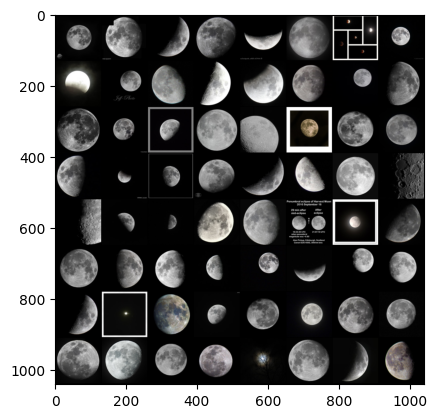

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    plt.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl):
    for images in dl:
        show_images(images)
        break
        
show_batch(dataset_loader)

## Model Intuition

### Discriminator and Generator

The __discriminator__ will be like a traditional neural network that classifies things. In our case, it will classify the images as real or fake.

The __generator__ will be a neural network that generates fake images, and such types of neural networks use deconvolution layers.

Now, it is clear why we need a generator. Because we want to generate fake images. The __generator__ will be trained on real images, learning the patterns, and will generate fake images based on those patterns.

Okay, but why do we need a __discriminator__? The reason is that we need to tell the __generator__ how good or bad it is at doing the job. We want to generate fake images that should look like real ones. So, the __discriminator__ will determine if the image generated by the __generator__ is real or not. The __generator__ should try to fool the __discriminator__ in such a way that it flags the fake image as real. And wait, if the __discriminator__, which is a neural network that classifies images as real or fake, is saying that an image created by the __generator__ is real, that means it is working.

So, the __discriminator__'s job is to classify the image as real or fake. And the __generator__'s job is to generate images that the __discriminator__ classifies as real.

## Discriminator and Generator

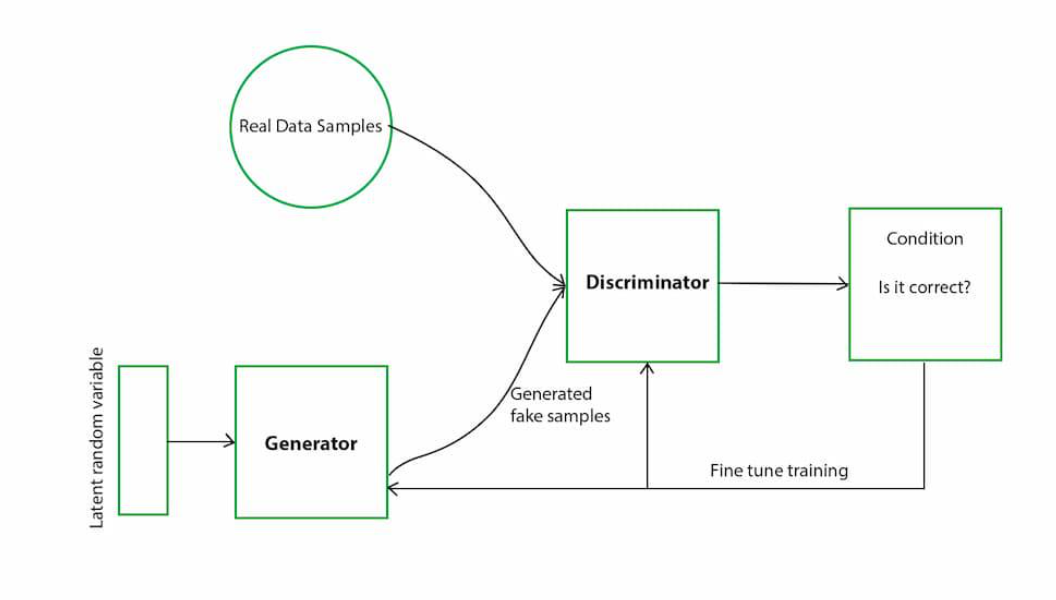

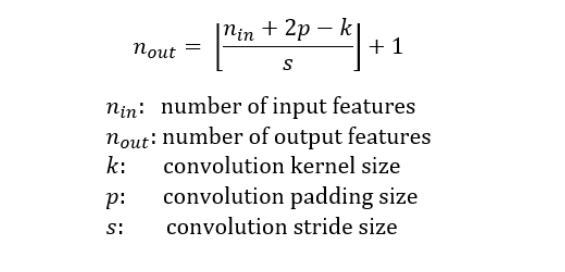

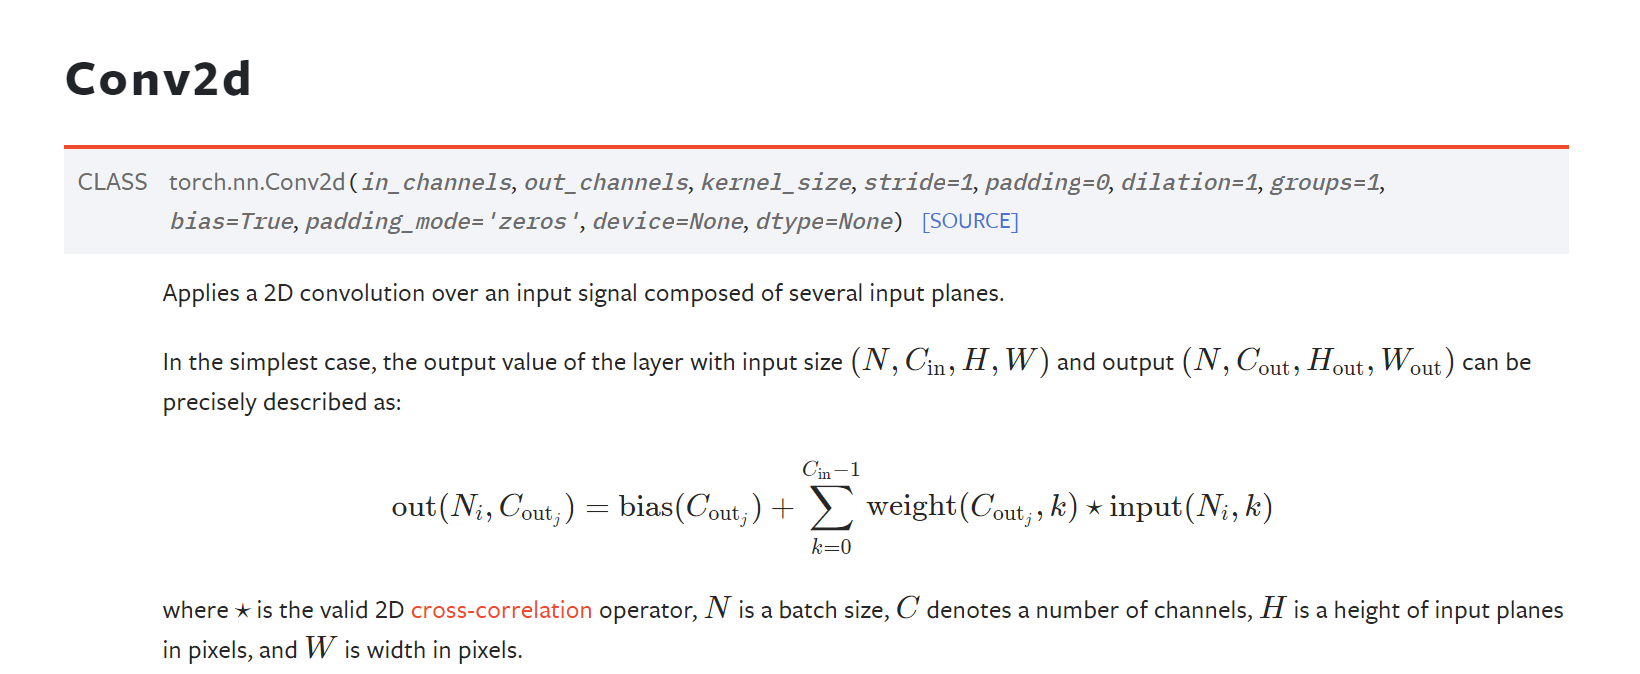

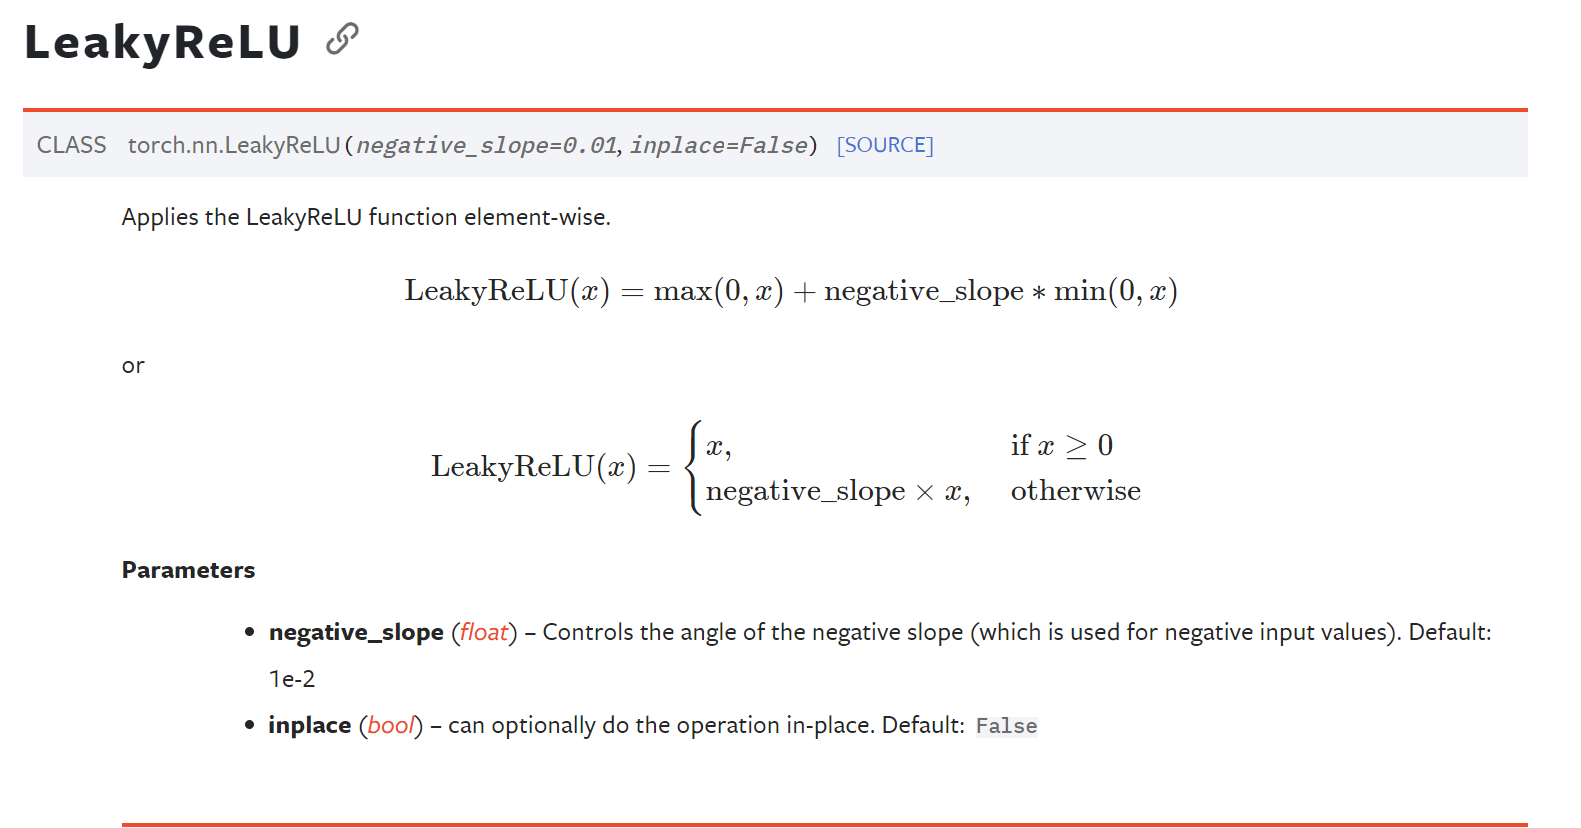

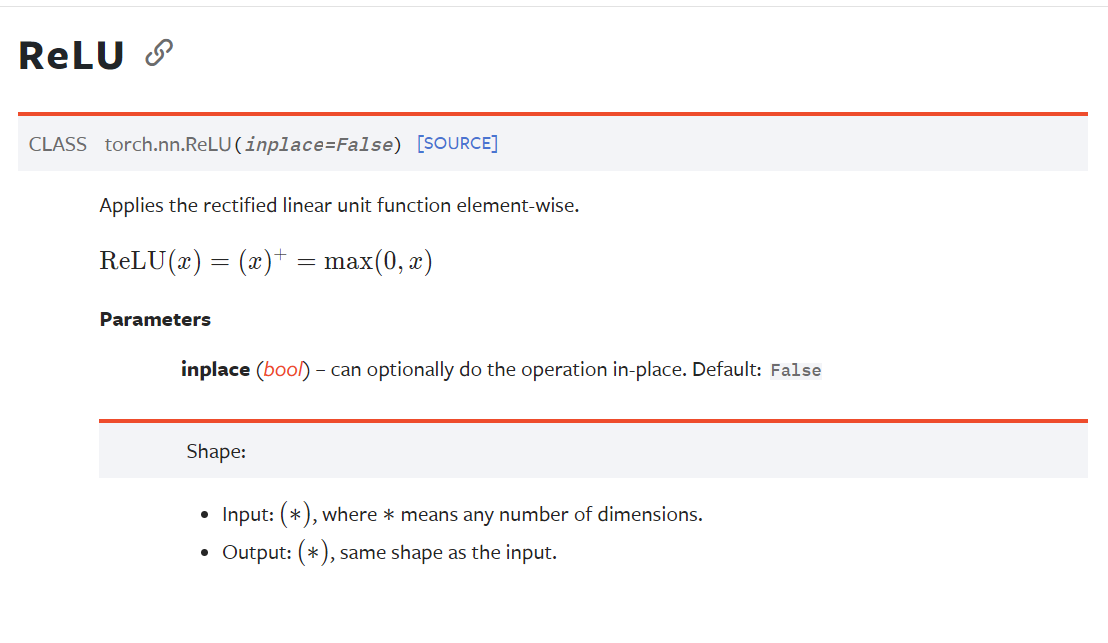

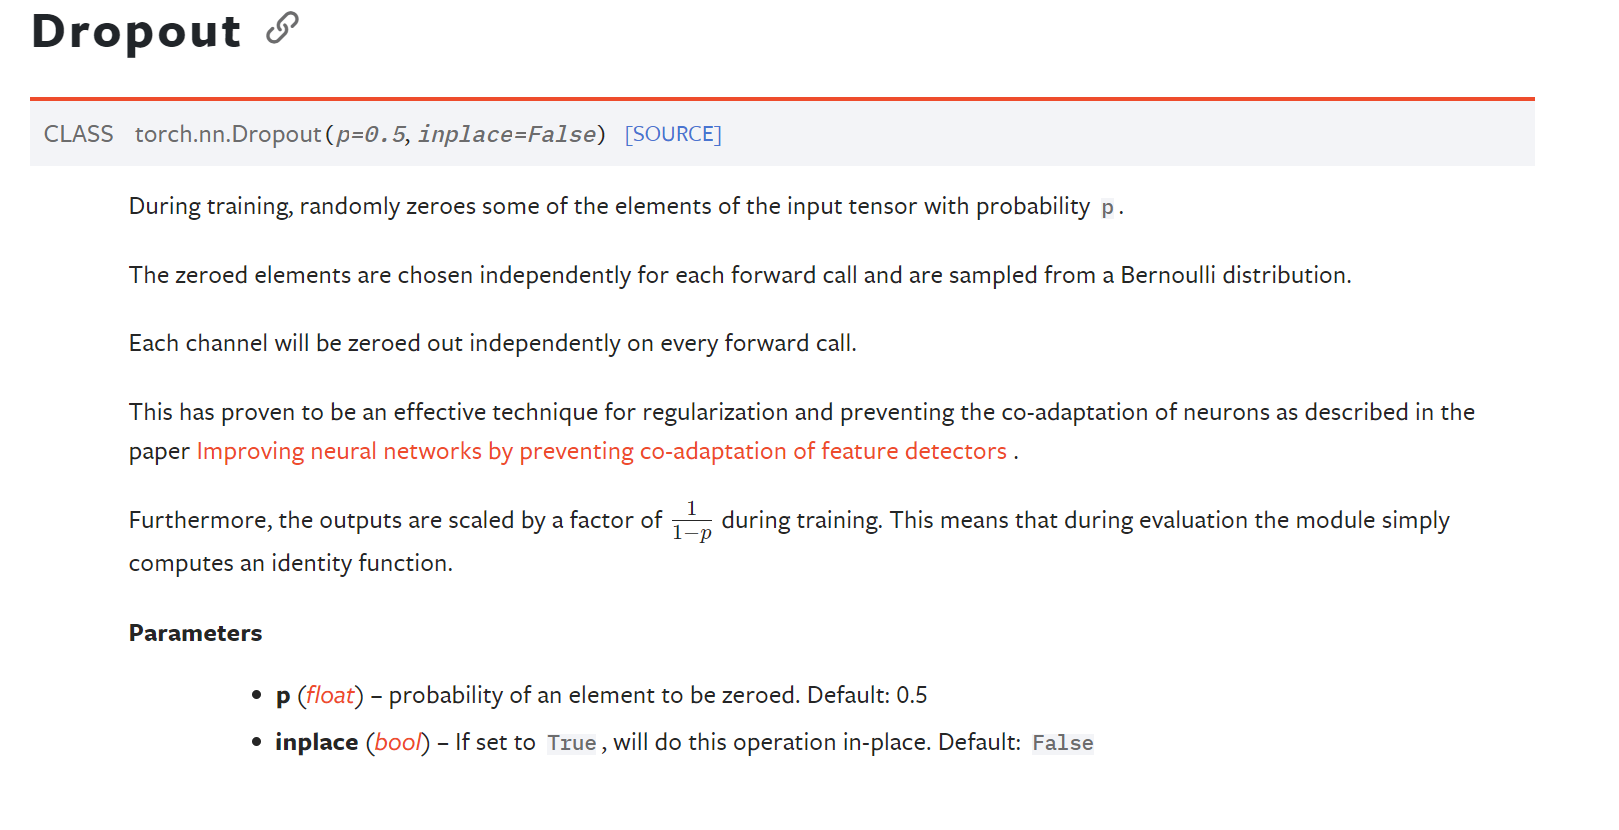

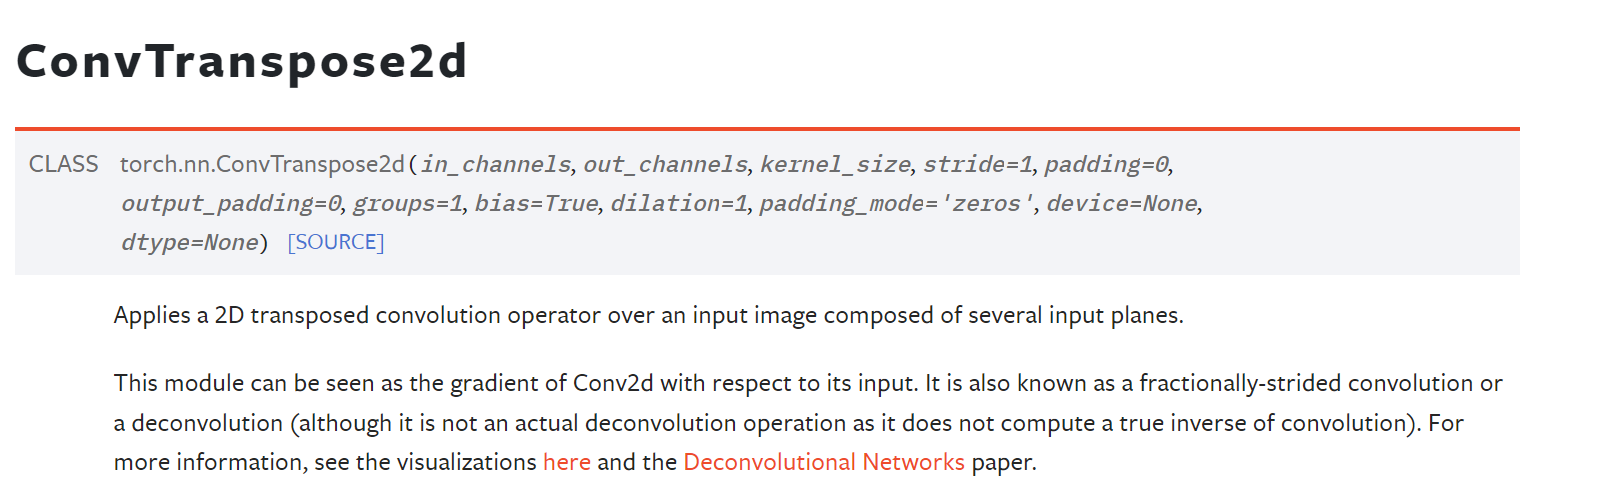

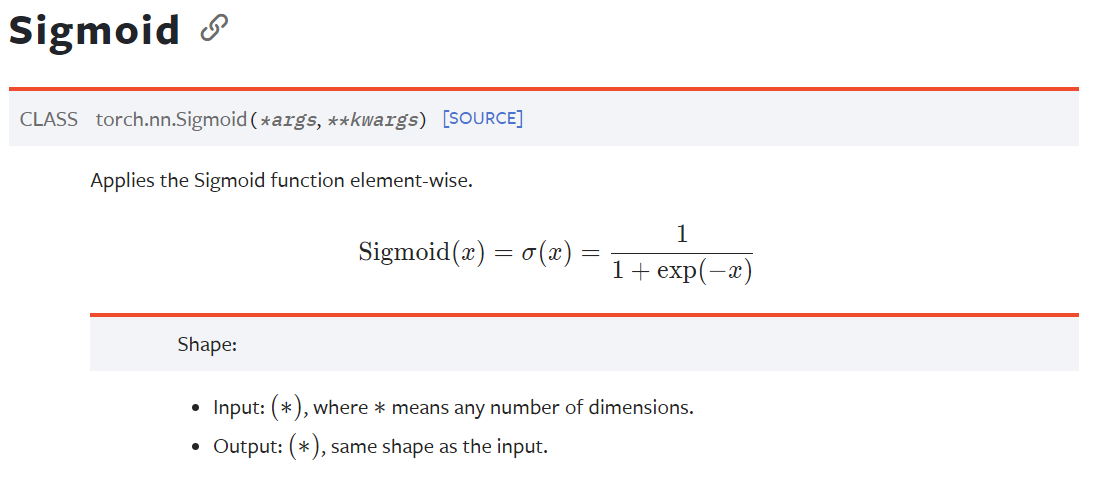

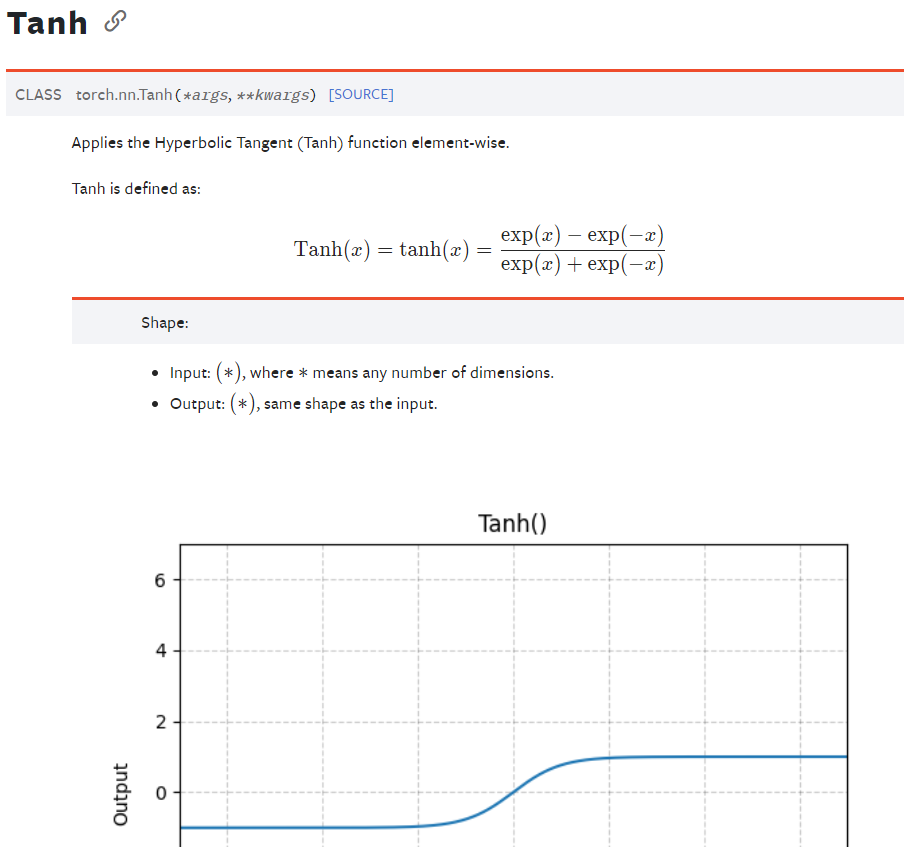

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 128x128, Output: (128 - 4 + 2*1) / 2 + 1 = 64x64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 64x64, Output: (64 - 4 + 2*1) / 2 + 1 = 32x32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 32x32, Output: (32 - 4 + 2*1) / 2 + 1 = 16x16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 16x16, Output: (16 - 4 + 2*1) / 2 + 1 = 8x8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 8x8, Output: (8 - 4 + 2*1) / 2 + 1 = 4x4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # Input: 4x4, Output: (4 - 4 + 0*0) / 1 + 1 = 1x1

            nn.Flatten(),
            nn.Sigmoid()  # Output range is (0, 1)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
latent_size = 512

class Generator(nn.Module):
    def __init__(self, latent_size=512):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=1024, kernel_size=4, stride=1, padding=0, bias=False),
            # Input: 1x1, Output: (1 - 1)*1 - 2*0 + 4 = 4x4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 4x4, Output: (4 - 1)*2 - 2*1 + 4 = 8x8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 8x8, Output: (8 - 1)*2 - 2*1 + 4 = 16x16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 16x16, Output: (16 - 1)*2 - 2*1 + 4 = 32x32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 32x32, Output: (32 - 1)*2 - 2*1 + 4 = 64x64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.1),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # Input: 64x64, Output: (64 - 1)*2 - 2*1 + 4 = 128x128
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, x):
        return self.model(x)


## Set GPU

In [9]:
def get_device():
    """
    Determines the best available device for computations (CPU or GPU).
    
    Returns:
        torch.device: The device ('cuda' or 'cpu') where tensors should be allocated.
    """
    if torch.cuda.is_available():
        return torch.device('cuda')  # Return a GPU device if CUDA is available
    else:
        return torch.device('cpu')   # Return CPU if CUDA is not available

def to_device(data, device):
    """
    Recursively moves tensors to the specified device.
    
    Args:
        data (tensor, list, tuple): Data to be moved to the device.
        device (torch.device): The device to move data to.
        
    Returns:
        Tensor or list of tensors moved to the specified device.
    """
    if isinstance(data, (list, tuple)):
        # Recursively move each item to the device if data is a list or tuple
        return [to_device(x, device) for x in data]
    else:
        # Move tensor to device asynchronously for performance
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """
    A wrapper around DataLoader to automatically move data to a device during iteration.
    """
    def __init__(self, dl, device):
        """
        Initializes the DeviceDataLoader.
        
        Args:
            dl (DataLoader): The DataLoader whose batches will be moved to the device.
            device (torch.device): The device to move data to.
        """
        self.dl = dl      # The DataLoader to wrap
        self.device = device  # The device to move data to

    def __iter__(self):
        """
        Yield a batch of data after moving it to the specified device.
        """
        for data in self.dl:
            yield to_device(data, self.device)  # Move each batch to device before yielding

    def __len__(self):
        """
        Returns the number of batches available in the DataLoader.
        """
        return len(self.dl)  # Return the length of the underlying DataLoader

In [10]:
torch.cuda.empty_cache()

device = get_device()
generator = Generator()
discriminator = Discriminator()

dataset_loader = DeviceDataLoader(dataset_loader, device)
print(f"Train loader device: {next(iter(dataset_loader))[0].device}")

discriminator = to_device(discriminator, device)
print(f"Discriminator device: {next(discriminator.parameters()).device}")

generator = to_device(generator, device)
print(f"Generator device: {next(generator.parameters()).device}")

Train loader device: cuda:0
Discriminator device: cuda:0
Generator device: cuda:0


### Training Intuition

__train_discriminator__
 - Pass the real image to this network.
 - Create a label, where the true label will be 1 because all images are real.
 - Use `binary_cross_entropy` to find the loss from the true label and predicted output. We call it `real_loss`, as this is the loss from training on the real image.
 - But we want our __discriminator__ to flag whether the image is true or fake, and in the above step, we have given it only real images. So we use the __generator__ to generate a fake image and use a label of 0 because all images from the __generator__ are fake.
 - Use `binary_cross_entropy` to find the loss again, and we call it `fake_loss`.
 - We add these losses and perform backpropagation.
 
__train_generator__
- Remember, any image is represented as an integer. So as input to the __generator__, we will use some random numbers, which we call latent in technical terms. 
- Once the __generator__ gives us some output, we will send this to the __discriminator__, which is trained on classifying real or fake images. We will take the __discriminator__ output for loss calculation using `binary_cross_entropy`.
- Okay, but we need two inputs for `binary_cross_entropy`, one is the true label and the other is the predicted label. From the above step, we will get the predicted label. 
- For getting the true label, we will create a label as 1, which means real. Why do we do that? Because the __generator__'s task is to generate real images. So the __discriminator__ will say it is fake, and we labeled it as real, and this will give a high loss from `binary_cross_entropy`. This loss gets backpropagated to update the __generator__ model.


## Training

torch.Size([64, 512, 1, 1])
torch.Size([64, 3, 128, 128])


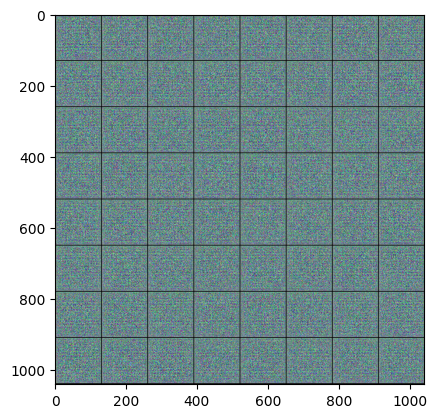

In [11]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(xb.shape)
print(fake_images.shape)
fake_images_cpu = fake_images.cpu()  # Move the tensor to CPU
show_images(fake_images_cpu)

In [12]:
def train_discriminator(real_images, opt_d):
    """
    Trains the discriminator network with both real and fake images.
    
    Args:
        real_images (torch.Tensor): A batch of real images.
        opt_d (torch.optim.Optimizer): The optimizer for the discriminator.
    
    Returns:
        tuple: Contains the total loss, mean probability score assigned to real images, 
               and mean probability score assigned to fake images.
    """
    # Clear previous gradients; important for correct gradient accumulation
    opt_d.zero_grad()

    # Forward pass real images through the discriminator to compute the loss on real images
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)  # Targets for real images
    real_loss = F.binary_cross_entropy(real_preds, real_targets)  # Compute BCE loss
    real_score = torch.mean(real_preds).item()  # Calculate the mean of the discriminator outputs for real images

    # Generate fake images from noise
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Sample random latent vector
    fake_images = generator(latent)  # Generate fake images using the generator

    # Forward pass fake images through the discriminator to compute the loss on fake images
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)  # Targets for fake images
    fake_preds = discriminator(fake_images)  # Discriminator predictions for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  # Compute BCE loss
    fake_score = torch.mean(fake_preds).item()  # Calculate the mean of the discriminator outputs for fake images

    # Combine losses and perform a backward pass to update the discriminator
    loss = real_loss + fake_loss  # Total loss for the discriminator
    loss.backward()  # Backpropagation
    opt_d.step()  # Update discriminator weights

    return loss.item(), real_score, fake_score  # Return the total loss and discriminator scores for real and fake images


In [13]:
def train_generator(opt_g):
    """
    Trains the generator network to improve its ability to generate realistic images.
    
    Args:
        opt_g (torch.optim.Optimizer): The optimizer for the generator.
    
    Returns:
        float: The loss value indicating how well the generator is fooling the discriminator.
    """
    # Clear previous gradients from the optimizer, necessary for correct gradient computation
    opt_g.zero_grad()

    # Generate a batch of fake images using random noise as input
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)  # Random noise vector
    fake_images = generator(latent)  # Generate fake images from noise

    # Forward pass fake images through the discriminator
    preds = discriminator(fake_images)  # Discriminator's predictions on the fake images
    targets = torch.ones(batch_size, 1, device=device)  # Set targets as 1, representing 'real'
    loss = F.binary_cross_entropy(preds, targets)  # Compute loss to fool the discriminator

    # Perform a backward pass to compute gradients
    loss.backward()  # Backpropagate to compute gradients
    opt_g.step()  # Update generator weights based on gradients

    return loss.item()  # Return the computed loss value

In [14]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [15]:
sample_dir = 'generated_images'
if os.path.exists(sample_dir):
    shutil.rmtree(sample_dir)
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, save_all, show):
    """
    Generates and saves sample images from latent tensors using a generator model.

    Args:
        index (int): The batch index used for naming the folder.
        latent_tensors (torch.Tensor): The input latent tensors for the generator.
        save_all (bool): If True, saves all generated images to disk.
        show (bool): If True, displays the generated images in a grid.

    Returns:
        None
    """
    fake_images = generator(latent_tensors)
    denorm_images = denorm(fake_images)

    if save_all:
        folder_name = 'batch-{0:0=4d}'.format(index)
        os.makedirs(os.path.join(sample_dir, folder_name), exist_ok=True)
        for i, image in enumerate(denorm_images):  # Loop through each image
            fake_fname = 'generated-image-{0:0=4d}.jpg'.format(i)  # Use index for filename
            save_image(image, os.path.join(sample_dir, folder_name, fake_fname))
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.imshow(make_grid(denorm_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [16]:
def fit(epochs, lr, start_idx=1):
    """
    Trains both the generator and discriminator networks over a specified number of epochs.
    
    Args:
        epochs (int): Total number of epochs to train.
        lr (float): Learning rate for the optimizers.
        start_idx (int): Starting index for saving generated samples.
    
    Returns:
        tuple: Lists containing the losses for the generator and discriminator, and scores for real and fake images.
    """
    torch.cuda.empty_cache()  # Clear GPU cache to free up unused memory and avoid CUDA errors

    # Initialize lists to store losses and scores for analysis
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Setup the optimizers for both networks with Adam optimizer
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr)
    
    # Loop over the dataset for a given number of epochs
    for epoch in tqdm(range(epochs), desc='Epochs'):
        batch_bar = 0
        for real_images in tqdm(dataset_loader, desc=f'Batchs for epoch: {epoch + 1}'):
            batch_bar += 1
            # Train the discriminator on real and generated fake images
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train the generator to improve at fooling the discriminator
            loss_g = train_generator(opt_g)

        # Save the losses and scores for this epoch
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print(f"Epoch: {epoch + 1} / {epochs}")
        
        if epoch % (epochs // 10) == 0:
            save_samples(epoch + start_idx, fixed_latent, show=False, save_all = True) 

        if epoch == epochs - 1 or epoch == 0:
            save_samples(epoch + start_idx, fixed_latent, show=True, save_all = True)  # Save first and last epoch sample images
            
    return losses_g, losses_d

Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Batchs for epoch: 1:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 1 / 500


Batchs for epoch: 2:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 2 / 500


Batchs for epoch: 3:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 3 / 500


Batchs for epoch: 4:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 4 / 500


Batchs for epoch: 5:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 5 / 500


Batchs for epoch: 6:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 6 / 500


Batchs for epoch: 7:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 7 / 500


Batchs for epoch: 8:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 8 / 500


Batchs for epoch: 9:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 9 / 500


Batchs for epoch: 10:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 10 / 500


Batchs for epoch: 11:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 11 / 500


Batchs for epoch: 12:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 12 / 500


Batchs for epoch: 13:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 13 / 500


Batchs for epoch: 14:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 14 / 500


Batchs for epoch: 15:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 15 / 500


Batchs for epoch: 16:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 16 / 500


Batchs for epoch: 17:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 17 / 500


Batchs for epoch: 18:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 18 / 500


Batchs for epoch: 19:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 19 / 500


Batchs for epoch: 20:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 20 / 500


Batchs for epoch: 21:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 21 / 500


Batchs for epoch: 22:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 22 / 500


Batchs for epoch: 23:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 23 / 500


Batchs for epoch: 24:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 24 / 500


Batchs for epoch: 25:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 25 / 500


Batchs for epoch: 26:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 26 / 500


Batchs for epoch: 27:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 27 / 500


Batchs for epoch: 28:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 28 / 500


Batchs for epoch: 29:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 29 / 500


Batchs for epoch: 30:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 30 / 500


Batchs for epoch: 31:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 31 / 500


Batchs for epoch: 32:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 32 / 500


Batchs for epoch: 33:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 33 / 500


Batchs for epoch: 34:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 34 / 500


Batchs for epoch: 35:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 35 / 500


Batchs for epoch: 36:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 36 / 500


Batchs for epoch: 37:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 37 / 500


Batchs for epoch: 38:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 38 / 500


Batchs for epoch: 39:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 39 / 500


Batchs for epoch: 40:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 40 / 500


Batchs for epoch: 41:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 41 / 500


Batchs for epoch: 42:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 42 / 500


Batchs for epoch: 43:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 43 / 500


Batchs for epoch: 44:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 44 / 500


Batchs for epoch: 45:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 45 / 500


Batchs for epoch: 46:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 46 / 500


Batchs for epoch: 47:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 47 / 500


Batchs for epoch: 48:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 48 / 500


Batchs for epoch: 49:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 49 / 500


Batchs for epoch: 50:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 50 / 500


Batchs for epoch: 51:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 51 / 500


Batchs for epoch: 52:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 52 / 500


Batchs for epoch: 53:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 53 / 500


Batchs for epoch: 54:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 54 / 500


Batchs for epoch: 55:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 55 / 500


Batchs for epoch: 56:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 56 / 500


Batchs for epoch: 57:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 57 / 500


Batchs for epoch: 58:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 58 / 500


Batchs for epoch: 59:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 59 / 500


Batchs for epoch: 60:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 60 / 500


Batchs for epoch: 61:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 61 / 500


Batchs for epoch: 62:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 62 / 500


Batchs for epoch: 63:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 63 / 500


Batchs for epoch: 64:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 64 / 500


Batchs for epoch: 65:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 65 / 500


Batchs for epoch: 66:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 66 / 500


Batchs for epoch: 67:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 67 / 500


Batchs for epoch: 68:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 68 / 500


Batchs for epoch: 69:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 69 / 500


Batchs for epoch: 70:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 70 / 500


Batchs for epoch: 71:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 71 / 500


Batchs for epoch: 72:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 72 / 500


Batchs for epoch: 73:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 73 / 500


Batchs for epoch: 74:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 74 / 500


Batchs for epoch: 75:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 75 / 500


Batchs for epoch: 76:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 76 / 500


Batchs for epoch: 77:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 77 / 500


Batchs for epoch: 78:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 78 / 500


Batchs for epoch: 79:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 79 / 500


Batchs for epoch: 80:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 80 / 500


Batchs for epoch: 81:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 81 / 500


Batchs for epoch: 82:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 82 / 500


Batchs for epoch: 83:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 83 / 500


Batchs for epoch: 84:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 84 / 500


Batchs for epoch: 85:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 85 / 500


Batchs for epoch: 86:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 86 / 500


Batchs for epoch: 87:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 87 / 500


Batchs for epoch: 88:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 88 / 500


Batchs for epoch: 89:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 89 / 500


Batchs for epoch: 90:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 90 / 500


Batchs for epoch: 91:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 91 / 500


Batchs for epoch: 92:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 92 / 500


Batchs for epoch: 93:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 93 / 500


Batchs for epoch: 94:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 94 / 500


Batchs for epoch: 95:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 95 / 500


Batchs for epoch: 96:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 96 / 500


Batchs for epoch: 97:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 97 / 500


Batchs for epoch: 98:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 98 / 500


Batchs for epoch: 99:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 99 / 500


Batchs for epoch: 100:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 100 / 500


Batchs for epoch: 101:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 101 / 500


Batchs for epoch: 102:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 102 / 500


Batchs for epoch: 103:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 103 / 500


Batchs for epoch: 104:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 104 / 500


Batchs for epoch: 105:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 105 / 500


Batchs for epoch: 106:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 106 / 500


Batchs for epoch: 107:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 107 / 500


Batchs for epoch: 108:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 108 / 500


Batchs for epoch: 109:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 109 / 500


Batchs for epoch: 110:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 110 / 500


Batchs for epoch: 111:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 111 / 500


Batchs for epoch: 112:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 112 / 500


Batchs for epoch: 113:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 113 / 500


Batchs for epoch: 114:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 114 / 500


Batchs for epoch: 115:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 115 / 500


Batchs for epoch: 116:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 116 / 500


Batchs for epoch: 117:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 117 / 500


Batchs for epoch: 118:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 118 / 500


Batchs for epoch: 119:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 119 / 500


Batchs for epoch: 120:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 120 / 500


Batchs for epoch: 121:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 121 / 500


Batchs for epoch: 122:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 122 / 500


Batchs for epoch: 123:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 123 / 500


Batchs for epoch: 124:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 124 / 500


Batchs for epoch: 125:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 125 / 500


Batchs for epoch: 126:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 126 / 500


Batchs for epoch: 127:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 127 / 500


Batchs for epoch: 128:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 128 / 500


Batchs for epoch: 129:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 129 / 500


Batchs for epoch: 130:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 130 / 500


Batchs for epoch: 131:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 131 / 500


Batchs for epoch: 132:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 132 / 500


Batchs for epoch: 133:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 133 / 500


Batchs for epoch: 134:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 134 / 500


Batchs for epoch: 135:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 135 / 500


Batchs for epoch: 136:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 136 / 500


Batchs for epoch: 137:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 137 / 500


Batchs for epoch: 138:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 138 / 500


Batchs for epoch: 139:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 139 / 500


Batchs for epoch: 140:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 140 / 500


Batchs for epoch: 141:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 141 / 500


Batchs for epoch: 142:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 142 / 500


Batchs for epoch: 143:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 143 / 500


Batchs for epoch: 144:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 144 / 500


Batchs for epoch: 145:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 145 / 500


Batchs for epoch: 146:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 146 / 500


Batchs for epoch: 147:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 147 / 500


Batchs for epoch: 148:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 148 / 500


Batchs for epoch: 149:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 149 / 500


Batchs for epoch: 150:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 150 / 500


Batchs for epoch: 151:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 151 / 500


Batchs for epoch: 152:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 152 / 500


Batchs for epoch: 153:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 153 / 500


Batchs for epoch: 154:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 154 / 500


Batchs for epoch: 155:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 155 / 500


Batchs for epoch: 156:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 156 / 500


Batchs for epoch: 157:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 157 / 500


Batchs for epoch: 158:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 158 / 500


Batchs for epoch: 159:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 159 / 500


Batchs for epoch: 160:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 160 / 500


Batchs for epoch: 161:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 161 / 500


Batchs for epoch: 162:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 162 / 500


Batchs for epoch: 163:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 163 / 500


Batchs for epoch: 164:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 164 / 500


Batchs for epoch: 165:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 165 / 500


Batchs for epoch: 166:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 166 / 500


Batchs for epoch: 167:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 167 / 500


Batchs for epoch: 168:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 168 / 500


Batchs for epoch: 169:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 169 / 500


Batchs for epoch: 170:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 170 / 500


Batchs for epoch: 171:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 171 / 500


Batchs for epoch: 172:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 172 / 500


Batchs for epoch: 173:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 173 / 500


Batchs for epoch: 174:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 174 / 500


Batchs for epoch: 175:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 175 / 500


Batchs for epoch: 176:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 176 / 500


Batchs for epoch: 177:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 177 / 500


Batchs for epoch: 178:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 178 / 500


Batchs for epoch: 179:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 179 / 500


Batchs for epoch: 180:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 180 / 500


Batchs for epoch: 181:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 181 / 500


Batchs for epoch: 182:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 182 / 500


Batchs for epoch: 183:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 183 / 500


Batchs for epoch: 184:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 184 / 500


Batchs for epoch: 185:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 185 / 500


Batchs for epoch: 186:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 186 / 500


Batchs for epoch: 187:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 187 / 500


Batchs for epoch: 188:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 188 / 500


Batchs for epoch: 189:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 189 / 500


Batchs for epoch: 190:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 190 / 500


Batchs for epoch: 191:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 191 / 500


Batchs for epoch: 192:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 192 / 500


Batchs for epoch: 193:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 193 / 500


Batchs for epoch: 194:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 194 / 500


Batchs for epoch: 195:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 195 / 500


Batchs for epoch: 196:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 196 / 500


Batchs for epoch: 197:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 197 / 500


Batchs for epoch: 198:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 198 / 500


Batchs for epoch: 199:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 199 / 500


Batchs for epoch: 200:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 200 / 500


Batchs for epoch: 201:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 201 / 500


Batchs for epoch: 202:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 202 / 500


Batchs for epoch: 203:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 203 / 500


Batchs for epoch: 204:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 204 / 500


Batchs for epoch: 205:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 205 / 500


Batchs for epoch: 206:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 206 / 500


Batchs for epoch: 207:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 207 / 500


Batchs for epoch: 208:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 208 / 500


Batchs for epoch: 209:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 209 / 500


Batchs for epoch: 210:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 210 / 500


Batchs for epoch: 211:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 211 / 500


Batchs for epoch: 212:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 212 / 500


Batchs for epoch: 213:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 213 / 500


Batchs for epoch: 214:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 214 / 500


Batchs for epoch: 215:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 215 / 500


Batchs for epoch: 216:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 216 / 500


Batchs for epoch: 217:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 217 / 500


Batchs for epoch: 218:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 218 / 500


Batchs for epoch: 219:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 219 / 500


Batchs for epoch: 220:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 220 / 500


Batchs for epoch: 221:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 221 / 500


Batchs for epoch: 222:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 222 / 500


Batchs for epoch: 223:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 223 / 500


Batchs for epoch: 224:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 224 / 500


Batchs for epoch: 225:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 225 / 500


Batchs for epoch: 226:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 226 / 500


Batchs for epoch: 227:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 227 / 500


Batchs for epoch: 228:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 228 / 500


Batchs for epoch: 229:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 229 / 500


Batchs for epoch: 230:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 230 / 500


Batchs for epoch: 231:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 231 / 500


Batchs for epoch: 232:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 232 / 500


Batchs for epoch: 233:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 233 / 500


Batchs for epoch: 234:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 234 / 500


Batchs for epoch: 235:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 235 / 500


Batchs for epoch: 236:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 236 / 500


Batchs for epoch: 237:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 237 / 500


Batchs for epoch: 238:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 238 / 500


Batchs for epoch: 239:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 239 / 500


Batchs for epoch: 240:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 240 / 500


Batchs for epoch: 241:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 241 / 500


Batchs for epoch: 242:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 242 / 500


Batchs for epoch: 243:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 243 / 500


Batchs for epoch: 244:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 244 / 500


Batchs for epoch: 245:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 245 / 500


Batchs for epoch: 246:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 246 / 500


Batchs for epoch: 247:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 247 / 500


Batchs for epoch: 248:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 248 / 500


Batchs for epoch: 249:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 249 / 500


Batchs for epoch: 250:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 250 / 500


Batchs for epoch: 251:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 251 / 500


Batchs for epoch: 252:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 252 / 500


Batchs for epoch: 253:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 253 / 500


Batchs for epoch: 254:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 254 / 500


Batchs for epoch: 255:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 255 / 500


Batchs for epoch: 256:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 256 / 500


Batchs for epoch: 257:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 257 / 500


Batchs for epoch: 258:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 258 / 500


Batchs for epoch: 259:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 259 / 500


Batchs for epoch: 260:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 260 / 500


Batchs for epoch: 261:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 261 / 500


Batchs for epoch: 262:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 262 / 500


Batchs for epoch: 263:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 263 / 500


Batchs for epoch: 264:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 264 / 500


Batchs for epoch: 265:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 265 / 500


Batchs for epoch: 266:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 266 / 500


Batchs for epoch: 267:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 267 / 500


Batchs for epoch: 268:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 268 / 500


Batchs for epoch: 269:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 269 / 500


Batchs for epoch: 270:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 270 / 500


Batchs for epoch: 271:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 271 / 500


Batchs for epoch: 272:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 272 / 500


Batchs for epoch: 273:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 273 / 500


Batchs for epoch: 274:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 274 / 500


Batchs for epoch: 275:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 275 / 500


Batchs for epoch: 276:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 276 / 500


Batchs for epoch: 277:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 277 / 500


Batchs for epoch: 278:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 278 / 500


Batchs for epoch: 279:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 279 / 500


Batchs for epoch: 280:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 280 / 500


Batchs for epoch: 281:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 281 / 500


Batchs for epoch: 282:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 282 / 500


Batchs for epoch: 283:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 283 / 500


Batchs for epoch: 284:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 284 / 500


Batchs for epoch: 285:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 285 / 500


Batchs for epoch: 286:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 286 / 500


Batchs for epoch: 287:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 287 / 500


Batchs for epoch: 288:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 288 / 500


Batchs for epoch: 289:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 289 / 500


Batchs for epoch: 290:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 290 / 500


Batchs for epoch: 291:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 291 / 500


Batchs for epoch: 292:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 292 / 500


Batchs for epoch: 293:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 293 / 500


Batchs for epoch: 294:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 294 / 500


Batchs for epoch: 295:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 295 / 500


Batchs for epoch: 296:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 296 / 500


Batchs for epoch: 297:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 297 / 500


Batchs for epoch: 298:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 298 / 500


Batchs for epoch: 299:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 299 / 500


Batchs for epoch: 300:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 300 / 500


Batchs for epoch: 301:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 301 / 500


Batchs for epoch: 302:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 302 / 500


Batchs for epoch: 303:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 303 / 500


Batchs for epoch: 304:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 304 / 500


Batchs for epoch: 305:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 305 / 500


Batchs for epoch: 306:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 306 / 500


Batchs for epoch: 307:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 307 / 500


Batchs for epoch: 308:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 308 / 500


Batchs for epoch: 309:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 309 / 500


Batchs for epoch: 310:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 310 / 500


Batchs for epoch: 311:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 311 / 500


Batchs for epoch: 312:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 312 / 500


Batchs for epoch: 313:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 313 / 500


Batchs for epoch: 314:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 314 / 500


Batchs for epoch: 315:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 315 / 500


Batchs for epoch: 316:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 316 / 500


Batchs for epoch: 317:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 317 / 500


Batchs for epoch: 318:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 318 / 500


Batchs for epoch: 319:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 319 / 500


Batchs for epoch: 320:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 320 / 500


Batchs for epoch: 321:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 321 / 500


Batchs for epoch: 322:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 322 / 500


Batchs for epoch: 323:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 323 / 500


Batchs for epoch: 324:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 324 / 500


Batchs for epoch: 325:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 325 / 500


Batchs for epoch: 326:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 326 / 500


Batchs for epoch: 327:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 327 / 500


Batchs for epoch: 328:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 328 / 500


Batchs for epoch: 329:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 329 / 500


Batchs for epoch: 330:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 330 / 500


Batchs for epoch: 331:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 331 / 500


Batchs for epoch: 332:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 332 / 500


Batchs for epoch: 333:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 333 / 500


Batchs for epoch: 334:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 334 / 500


Batchs for epoch: 335:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 335 / 500


Batchs for epoch: 336:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 336 / 500


Batchs for epoch: 337:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 337 / 500


Batchs for epoch: 338:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 338 / 500


Batchs for epoch: 339:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 339 / 500


Batchs for epoch: 340:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 340 / 500


Batchs for epoch: 341:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 341 / 500


Batchs for epoch: 342:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 342 / 500


Batchs for epoch: 343:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 343 / 500


Batchs for epoch: 344:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 344 / 500


Batchs for epoch: 345:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 345 / 500


Batchs for epoch: 346:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 346 / 500


Batchs for epoch: 347:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 347 / 500


Batchs for epoch: 348:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 348 / 500


Batchs for epoch: 349:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 349 / 500


Batchs for epoch: 350:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 350 / 500


Batchs for epoch: 351:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 351 / 500


Batchs for epoch: 352:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 352 / 500


Batchs for epoch: 353:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 353 / 500


Batchs for epoch: 354:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 354 / 500


Batchs for epoch: 355:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 355 / 500


Batchs for epoch: 356:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 356 / 500


Batchs for epoch: 357:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 357 / 500


Batchs for epoch: 358:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 358 / 500


Batchs for epoch: 359:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 359 / 500


Batchs for epoch: 360:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 360 / 500


Batchs for epoch: 361:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 361 / 500


Batchs for epoch: 362:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 362 / 500


Batchs for epoch: 363:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 363 / 500


Batchs for epoch: 364:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 364 / 500


Batchs for epoch: 365:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 365 / 500


Batchs for epoch: 366:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 366 / 500


Batchs for epoch: 367:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 367 / 500


Batchs for epoch: 368:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 368 / 500


Batchs for epoch: 369:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 369 / 500


Batchs for epoch: 370:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 370 / 500


Batchs for epoch: 371:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 371 / 500


Batchs for epoch: 372:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 372 / 500


Batchs for epoch: 373:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 373 / 500


Batchs for epoch: 374:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 374 / 500


Batchs for epoch: 375:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 375 / 500


Batchs for epoch: 376:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 376 / 500


Batchs for epoch: 377:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 377 / 500


Batchs for epoch: 378:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 378 / 500


Batchs for epoch: 379:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 379 / 500


Batchs for epoch: 380:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 380 / 500


Batchs for epoch: 381:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 381 / 500


Batchs for epoch: 382:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 382 / 500


Batchs for epoch: 383:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 383 / 500


Batchs for epoch: 384:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 384 / 500


Batchs for epoch: 385:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 385 / 500


Batchs for epoch: 386:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 386 / 500


Batchs for epoch: 387:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 387 / 500


Batchs for epoch: 388:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 388 / 500


Batchs for epoch: 389:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 389 / 500


Batchs for epoch: 390:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 390 / 500


Batchs for epoch: 391:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 391 / 500


Batchs for epoch: 392:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 392 / 500


Batchs for epoch: 393:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 393 / 500


Batchs for epoch: 394:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 394 / 500


Batchs for epoch: 395:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 395 / 500


Batchs for epoch: 396:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 396 / 500


Batchs for epoch: 397:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 397 / 500


Batchs for epoch: 398:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 398 / 500


Batchs for epoch: 399:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 399 / 500


Batchs for epoch: 400:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 400 / 500


Batchs for epoch: 401:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 401 / 500


Batchs for epoch: 402:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 402 / 500


Batchs for epoch: 403:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 403 / 500


Batchs for epoch: 404:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 404 / 500


Batchs for epoch: 405:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 405 / 500


Batchs for epoch: 406:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 406 / 500


Batchs for epoch: 407:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 407 / 500


Batchs for epoch: 408:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 408 / 500


Batchs for epoch: 409:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 409 / 500


Batchs for epoch: 410:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 410 / 500


Batchs for epoch: 411:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 411 / 500


Batchs for epoch: 412:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 412 / 500


Batchs for epoch: 413:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 413 / 500


Batchs for epoch: 414:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 414 / 500


Batchs for epoch: 415:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 415 / 500


Batchs for epoch: 416:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 416 / 500


Batchs for epoch: 417:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 417 / 500


Batchs for epoch: 418:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 418 / 500


Batchs for epoch: 419:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 419 / 500


Batchs for epoch: 420:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 420 / 500


Batchs for epoch: 421:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 421 / 500


Batchs for epoch: 422:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 422 / 500


Batchs for epoch: 423:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 423 / 500


Batchs for epoch: 424:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 424 / 500


Batchs for epoch: 425:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 425 / 500


Batchs for epoch: 426:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 426 / 500


Batchs for epoch: 427:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 427 / 500


Batchs for epoch: 428:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 428 / 500


Batchs for epoch: 429:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 429 / 500


Batchs for epoch: 430:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 430 / 500


Batchs for epoch: 431:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 431 / 500


Batchs for epoch: 432:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 432 / 500


Batchs for epoch: 433:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 433 / 500


Batchs for epoch: 434:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 434 / 500


Batchs for epoch: 435:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 435 / 500


Batchs for epoch: 436:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 436 / 500


Batchs for epoch: 437:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 437 / 500


Batchs for epoch: 438:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 438 / 500


Batchs for epoch: 439:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 439 / 500


Batchs for epoch: 440:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 440 / 500


Batchs for epoch: 441:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 441 / 500


Batchs for epoch: 442:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 442 / 500


Batchs for epoch: 443:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 443 / 500


Batchs for epoch: 444:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 444 / 500


Batchs for epoch: 445:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 445 / 500


Batchs for epoch: 446:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 446 / 500


Batchs for epoch: 447:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 447 / 500


Batchs for epoch: 448:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 448 / 500


Batchs for epoch: 449:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 449 / 500


Batchs for epoch: 450:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 450 / 500


Batchs for epoch: 451:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 451 / 500


Batchs for epoch: 452:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 452 / 500


Batchs for epoch: 453:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 453 / 500


Batchs for epoch: 454:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 454 / 500


Batchs for epoch: 455:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 455 / 500


Batchs for epoch: 456:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 456 / 500


Batchs for epoch: 457:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 457 / 500


Batchs for epoch: 458:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 458 / 500


Batchs for epoch: 459:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 459 / 500


Batchs for epoch: 460:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 460 / 500


Batchs for epoch: 461:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 461 / 500


Batchs for epoch: 462:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 462 / 500


Batchs for epoch: 463:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 463 / 500


Batchs for epoch: 464:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 464 / 500


Batchs for epoch: 465:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 465 / 500


Batchs for epoch: 466:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 466 / 500


Batchs for epoch: 467:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 467 / 500


Batchs for epoch: 468:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 468 / 500


Batchs for epoch: 469:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 469 / 500


Batchs for epoch: 470:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 470 / 500


Batchs for epoch: 471:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 471 / 500


Batchs for epoch: 472:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 472 / 500


Batchs for epoch: 473:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 473 / 500


Batchs for epoch: 474:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 474 / 500


Batchs for epoch: 475:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 475 / 500


Batchs for epoch: 476:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 476 / 500


Batchs for epoch: 477:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 477 / 500


Batchs for epoch: 478:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 478 / 500


Batchs for epoch: 479:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 479 / 500


Batchs for epoch: 480:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 480 / 500


Batchs for epoch: 481:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 481 / 500


Batchs for epoch: 482:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 482 / 500


Batchs for epoch: 483:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 483 / 500


Batchs for epoch: 484:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 484 / 500


Batchs for epoch: 485:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 485 / 500


Batchs for epoch: 486:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 486 / 500


Batchs for epoch: 487:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 487 / 500


Batchs for epoch: 488:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 488 / 500


Batchs for epoch: 489:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 489 / 500


Batchs for epoch: 490:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 490 / 500


Batchs for epoch: 491:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 491 / 500


Batchs for epoch: 492:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 492 / 500


Batchs for epoch: 493:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 493 / 500


Batchs for epoch: 494:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 494 / 500


Batchs for epoch: 495:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 495 / 500


Batchs for epoch: 496:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 496 / 500


Batchs for epoch: 497:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 497 / 500


Batchs for epoch: 498:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 498 / 500


Batchs for epoch: 499:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 499 / 500


Batchs for epoch: 500:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch: 500 / 500


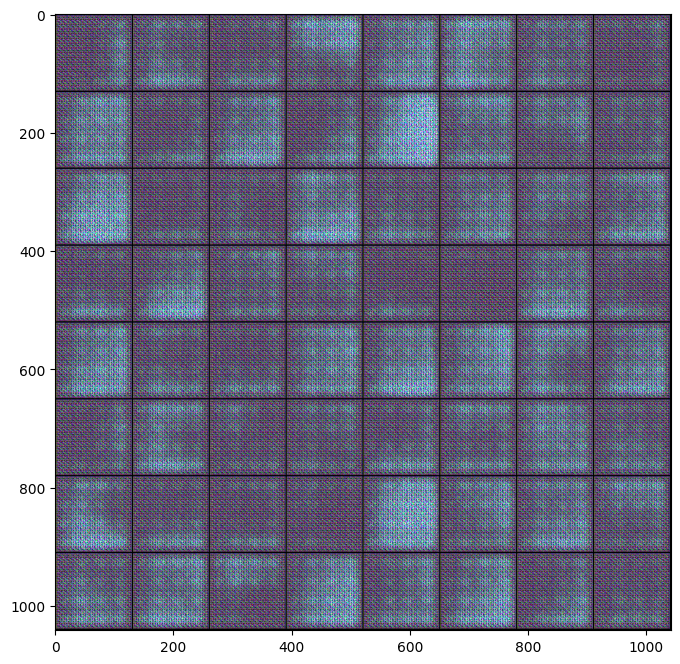

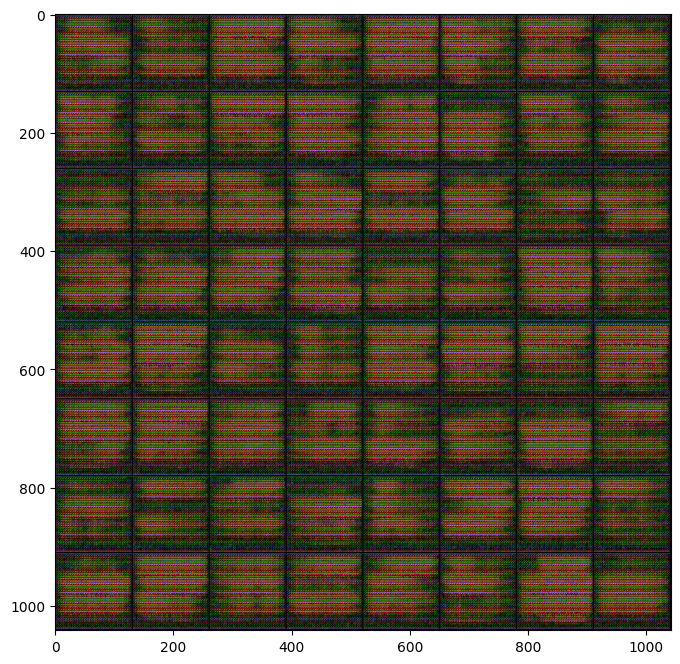

In [17]:
lr = 0.001
epochs = 500
history = fit(epochs, lr)

In [18]:
# save the model
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

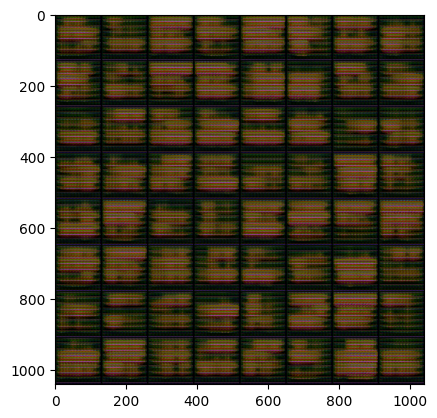

In [19]:
pred_generator = Generator()
pred_generator.load_state_dict(torch.load('G.pth'))
pred_generator.eval()

pred_generator = to_device(pred_generator, device)
output = pred_generator(fixed_latent)

plt.imshow(make_grid(output.cpu().detach(), nrow=8).permute(1, 2, 0))

## Useful link

__[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)__

__[ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)__

__[Animation](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)__

__[MNIST Neural Network from scratch](https://www.kaggle.com/code/siddp6/mnist-neural-network-from-scratch)__

__[Linear-Regression-Neural-Network-from-scratch](https://www.kaggle.com/code/siddp6/linear-regression-neural-network-from-scratch)__